In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import AdamW, Muon
import matplotlib.pyplot as plt

from pathlib import Path

from MaskedDiffusion.model import MaskedDiffusion
from MaskingSchedule.MaskingSchedule import LinearSchedule, PolynomialSchedule, GeometricSchedule, CosineSchedule
from Config import Config
from tokenization.tokenization import tokens_to_fen, FENTokens


In [2]:
base_path = Path("./dataset")
fen_tokens = torch.load(base_path / "fen_tokens.pt")
theme_tokens = torch.load(base_path / "theme_tokens.pt")
ratings = torch.load(base_path / "ratings.pt")

print(fen_tokens.shape, theme_tokens.shape, ratings.shape)
print(fen_tokens, theme_tokens, ratings)

torch.Size([5600086, 76]) torch.Size([5600086, 66]) torch.Size([5600086])
tensor([[10,  0,  0,  ..., 37, 40, 43],
        [ 0,  0,  0,  ..., 37, 40, 45],
        [ 0,  0,  0,  ..., 37, 44, 42],
        ...,
        [ 0,  0,  0,  ..., 37, 40, 47],
        [ 0,  0,  0,  ..., 37, 41, 44],
        [ 0,  0,  0,  ..., 37, 42, 41]], dtype=torch.int8) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8) tensor([0.4934, 0.3679, 0.3191,  ..., 0.2593, 0.1713, 0.3110],
       dtype=torch.float16)


In [7]:
dataset = TensorDataset(fen_tokens, theme_tokens, ratings)
train_set, test_set = random_split(dataset, [0.99, 0.01])

len(train_set), len(test_set)

(5544086, 56000)

In [ ]:
# torch.save(train_set, base_path / "train" / "trainset.pt")
# torch.save(test_set, base_path / "validation" / "validationset.pt")

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

config = Config(n_layers=1, batch_size=3)
model = MaskedDiffusion(config)
model.to(device=device, dtype=torch.float32)  # bfloat16

total = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        # print(f"{name:40} | {param.numel():,}")
        total += param.numel()
print(f"Total parameters: {total:,}")

Total parameters: 12,834,816


In [4]:
dataset = TensorDataset(fen_tokens, theme_tokens, ratings)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
n = 2
model.sample(theme_tokens[0:n].to(torch.float32), ratings[0:n].to(torch.float32), steps=50)

tensor([[21,  8, 17, 43,  7, 43, 15, 32, 19, 41, 18, 45, 43, 46, 21, 16,  6, 43,
         14, 39, 17, 41, 22,  7, 32, 14,  1,  8, 43,  7, 36, 43, 16, 10, 21, 15,
         32, 10, 42, 17, 14, 44, 37, 33, 43, 23, 47, 12, 46, 47, 34, 46, 40, 30,
          3, 19, 43,  2, 22, 10, 28, 10,  8, 44, 14,  8, 24, 47, 44, 15, 10, 46,
          7,  7, 36, 26],
        [ 7, 47, 32, 19, 21,  2, 29, 14, 44, 47, 38, 16, 34, 40,  0, 43, 23, 47,
         20,  7,  8,  7, 13, 43, 20, 31, 15,  7, 26, 24, 12, 12, 43, 28, 10,  3,
         47,  7,  7,  7, 27, 45, 20, 45,  2,  7,  7, 32,  7, 43, 26, 15,  3, 14,
         44, 41, 11, 36, 34, 20,  7, 27,  7, 17, 14, 12, 17, 43, 27,  7, 44, 46,
          7, 40,  7, 24]])

In [6]:
true_fen = torch.zeros((1, config.fen_length)).to(torch.long)
masked_fen = torch.zeros_like(true_fen).to(torch.long)
masked_fen[:, 0] = config.mask_token
masked_fen[:, 1] = config.mask_token

logits = torch.zeros((1, config.fen_length, config.embed_dim))
logits[:, 0, 0] = 10
logits[:, 1, 0] = 10


model.elbo_loss(torch.tensor([0.5]), logits, true_fen, masked_fen)

tensor([[-1.5708]])
tensor([[0.0454, 0.0454, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315, 6.9315,
         6.9315, 6.9315, 6.9315, 6.9315]])
tensor([[ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

tensor(-0.1427)

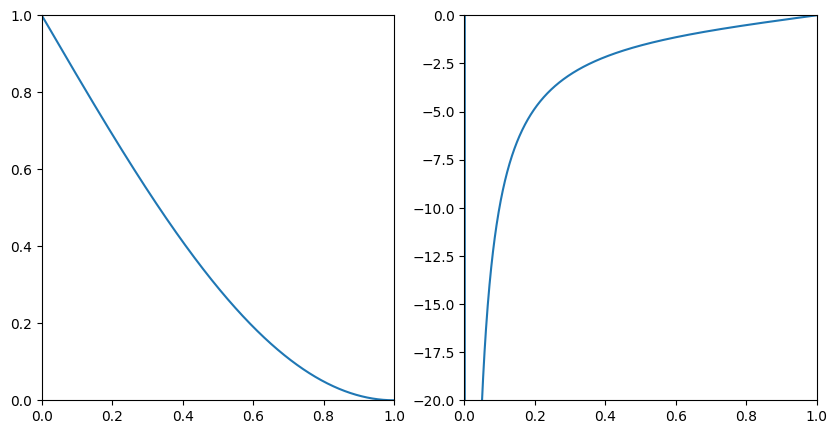

In [ ]:
t = torch.linspace(0, 1, 1000)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(t, config.masking_schedule(t))
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(122)
plt.plot(t, config.masking_schedule.get_weight(t))
plt.xlim(0, 1)
plt.ylim(-20, 0)
plt.show()